In [10]:
import pandas as pd
import numpy as np
import json
import re
from pathlib import Path

In [12]:
#Loading the dataset

def load_jsonl_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

df = load_jsonl_data("D:\AutoJudge_v2\data\merged_problems.jsonl")

print(f"Dataset shape: {df.shape}")
print(f"\nColumns : {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (5000, 6)

Columns : ['title', 'description', 'input_description', 'output_description', 'problem_class', 'problem_score']

First few rows:


,title,description,input_description,output_description,problem_class,problem_score
0,Digits,John gave Jack a very hard problem. He wrote a...,First line contains a positive integer N (1 ≤ ...,"Output exactly three lines, the steps Jack nee...",hard,7.95
1,Neural Network country,Due to the recent popularity of the Deep learn...,The first line of input contains N (1 ≤ N ≤ 10...,"Output a single integer, the number of paths D...",hard,5.91
2,Property,Bill is a famous mathematician in BubbleLand. ...,The first line contains one integer number n (...,Output contains n distinct integers separated ...,hard,6.32
3,Exploration plan,The competitors of Bubble Cup X gathered after...,"The first line contains four integers: V, E, N...",Output a single integer that represents the mi...,hard,6.32
4,Casinos and travel,John has just bought a new car and is planning...,"In the first line, a positive integer N (1 ≤ N...","Output one number, the answer to the problem m...",hard,6.32


***Exploratory Data Analysis***

In [13]:
#Dataset Overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               5000 non-null   object 
 1   description         5000 non-null   object 
 2   input_description   5000 non-null   object 
 3   output_description  5000 non-null   object 
 4   problem_class       5000 non-null   object 
 5   problem_score       5000 non-null   float64
dtypes: float64(1), object(5)
memory usage: 234.5+ KB


In [14]:
df.isnull().sum()

title                 0
description           0
input_description     0
output_description    0
problem_class         0
problem_score         0
dtype: int64

In [15]:
df['problem_class'].value_counts()

problem_class
hard      2578
medium    1434
easy       988
Name: count, dtype: int64

In [16]:
df['problem_score'].describe()

count    5000.000000
mean        5.202780
std         2.736511
min         1.000000
25%         3.050000
50%         5.090000
75%         7.550000
max        10.000000
Name: problem_score, dtype: float64

In [17]:
#visualizing class distribution

import matplotlib.pyplot as plt
import seaborn as sns

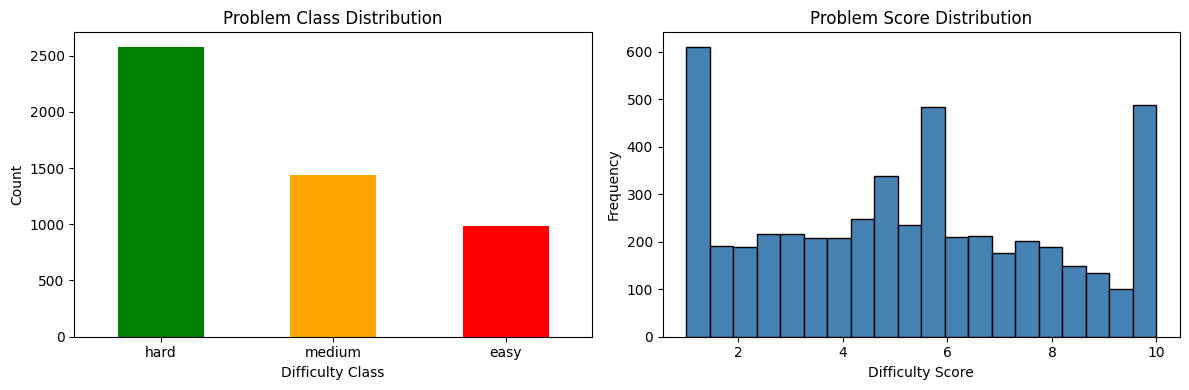

In [18]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
df['problem_class'].value_counts().plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Problem Class Distribution')
plt.xlabel('Difficulty Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
plt.hist(df['problem_score'], bins=20, color='steelblue', edgecolor='black')
plt.title('Problem Score Distribution')
plt.xlabel('Difficulty Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

***Data Cleaning***

In [19]:
df_clean = df.copy()

In [20]:
# Fill missing text fields with empty strings
text_columns = ['title', 'description', 'input_description', 'output_description']
for col in text_columns:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna('')

print(f"\nAfter cleaning - Missing values:")
print(df_clean.isnull().sum())


After cleaning - Missing values:
title                 0
description           0
input_description     0
output_description    0
problem_class         0
problem_score         0
dtype: int64


In [21]:
import collections.abc

def make_hashable(x):
    # None / simple scalars stay as-is
    if isinstance(x, (str, int, float, bool, type(None))):
        return x
    
    # dict → tuple of sorted (key, value) pairs, both converted recursively
    if isinstance(x, dict):
        return tuple(sorted((k, make_hashable(v)) for k, v in x.items()))
    
    # list / tuple / set / other iterables → tuple of converted values
    if isinstance(x, collections.abc.Iterable):
        try:
            return tuple(make_hashable(i) for i in x)
        except TypeError:
            pass  # fallback below
    
    # fallback: convert to string
    return str(x)

df_clean = df_clean.applymap(make_hashable)

df_clean = df_clean.drop_duplicates()

print(f"\nRows after removing duplicates: {len(df_clean)}")


Rows after removing duplicates: 4999


C:\Users\RITESH KUMAR\AppData\Local\Temp\ipykernel_23764\2142818642.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_clean = df_clean.applymap(make_hashable)


In [22]:
# Text Preprocessing Functions

def clean_text(text):
    """Clean text by removing extra whitespace and special characters"""
    if pd.isna(text) or text == '':
        return ''
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove leading/trailing whitespace
    text = text.strip()
    
    return text

def combine_text_fields(row):
    """Combine all text fields into one"""
    texts = [
        row.get('title', ''),
        row.get('description', ''),
        row.get('input_description', ''),
        row.get('output_description', '')
    ]
    combined = ' '.join([str(t) for t in texts if t])
    return clean_text(combined)

In [23]:
#Applying Text cleaning

for col in text_columns:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].apply(clean_text)

# Create combined text field
df_clean['combined_text'] = df_clean.apply(combine_text_fields, axis=1)

print("\nCombined text sample:")
print(df_clean['combined_text'].iloc[0][:200] + "...")


Combined text sample:
Digits John gave Jack a very hard problem. He wrote a very big positive integer A0 on a piece of paper. The number is less than 10200000 . In each step, Jack is allowed to put ' + ' signs in between s...


***Label Encoding for Classification***

In [24]:
from sklearn.preprocessing import LabelEncoder

In [25]:
le = LabelEncoder()
df_clean['problem_class_encoded'] = le.fit_transform(df_clean['problem_class'])

print("\n" + "="*50)
print("LABEL ENCODING")
print("="*50)
print("\nClass mapping:")
for i, label in enumerate(le.classes_):
    print(f"{label}: {i}")


LABEL ENCODING

Class mapping:
easy: 0
hard: 1
medium: 2


***Basic Text Statistics***

In [26]:
df_clean['text_length'] = df_clean['combined_text'].str.len()
df_clean['word_count'] = df_clean['combined_text'].str.split().str.len()

print("\n" + "="*50)
print("TEXT STATISTICS")
print("="*50)
print("\nText length by class:")
print(df_clean.groupby('problem_class')['text_length'].describe())

print("\nWord count by class:")
print(df_clean.groupby('problem_class')['word_count'].describe())


TEXT STATISTICS

Text length by class:
                count         mean         std    min     25%     50%     75%  \
problem_class                                                                   
easy            988.0  1705.974696  629.444629   61.0  1252.5  1664.0  2089.5   
hard           2577.0  2100.645712  891.600561  193.0  1499.0  1997.0  2544.0   
medium         1434.0  1872.278243  877.920494  125.0  1308.0  1769.0  2329.0   

                   max  
problem_class           
easy            4721.0  
hard           13003.0  
medium         10831.0  

Word count by class:
                count        mean         std   min     25%    50%     75%  \
problem_class                                                                
easy            988.0  301.224696  110.282644   8.0  223.75  293.0  364.25   
hard           2577.0  374.793558  155.728827  31.0  269.00  357.0  455.00   
medium         1434.0  332.196653  151.988661  20.0  232.00  315.0  411.00   

                

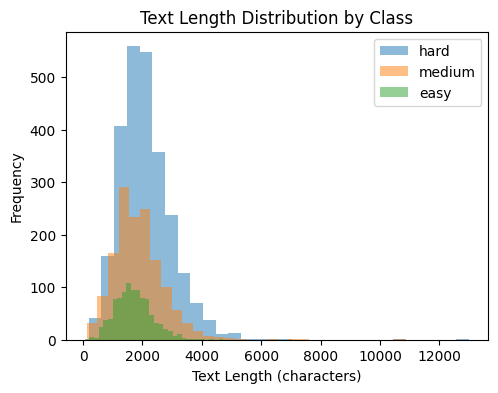

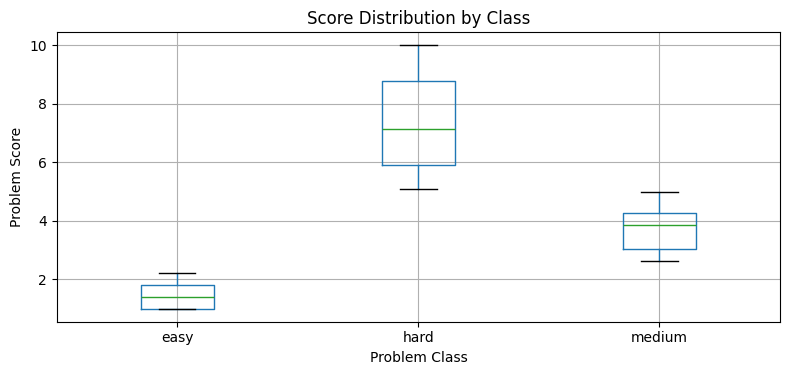

In [27]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 2)
for cls in df_clean['problem_class'].unique():
    data = df_clean[df_clean['problem_class'] == cls]['text_length']
    plt.hist(data, alpha=0.5, label=cls, bins=30)
plt.title('Text Length Distribution by Class')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
df_clean.boxplot(column='problem_score', by='problem_class', figsize=(8, 4))
plt.title('Score Distribution by Class')
plt.suptitle('')
plt.xlabel('Problem Class')
plt.ylabel('Problem Score')

plt.tight_layout()
plt.show()

***Saving Cleaned dataset***

In [28]:
df_clean.to_csv('D:\AutoJudge_v2\data\data_cleaned.csv', index=False)
print("\n✓ Cleaned data saved to 'data_cleaned.csv'")


✓ Cleaned data saved to 'data_cleaned.csv'


In [29]:
# Saving label encoder
import pickle

with open(r'D:\AutoJudge_v2\models\label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("✓ Label encoder saved to models/label_encoder.pkl")

✓ Label encoder saved to models/label_encoder.pkl


In [30]:
# Saving summary statistics
summary = {
    'total_samples': len(df_clean),
    'class_distribution': df_clean['problem_class'].value_counts().to_dict(),
    'score_stats': df_clean['problem_score'].describe().to_dict(),
    'text_length_stats': df_clean['text_length'].describe().to_dict(),
    'class_mapping': {label: int(i) for i, label in enumerate(le.classes_)}
}

with open(r'D:\AutoJudge_v2\data\data_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)
print("✓ Data summary saved to 'data_summary.json'")

print("\n" + "="*50)
print("PREPROCESSING COMPLETE!")
print("="*50)
print(f"Final dataset shape: {df_clean.shape}")
print(f"Ready for feature engineering!")

✓ Data summary saved to 'data_summary.json'

PREPROCESSING COMPLETE!
Final dataset shape: (4999, 10)
Ready for feature engineering!
